# WHOLE experimentation


## Loading data and dependencies

###  Load the necessary packages

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [30]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import *
import torch
import torch.optim as optim

from fastai import *
from fastai.text import *
from pytorch_transformers import *


from fastai.basic_train import *
from fastai.basic_train import BasicLearner
import sys
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_selection import chi2
import numpy as np

In [3]:



from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score

In [3]:
## load ggplot support

import rpy2

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

###  Read in the data and split them

#### Read and process Ag_news data

In [5]:
DATA = Path(os.getcwd())/'Data'
AG_NEWS = Path(os.getcwd())/'Data'/'Ag_news'
header = ['class', 'title', 'describ']

In [5]:

#AG_NEWS_train = pd.read_csv(AG_NEWS_folder/'train.csv', names = header)

# sample a smaller version  


# AG_NEWS_TRAIN = AG_NEWS_TRAIN.iloc[:, 1:4]
# AG_NEWS_TRAIN.head()


In [6]:
# set the class dict for the class col
class_dict = {1: 'world', 
             2: 'sports',
             3: 'business',
             4: 'sci_tech'}

In [7]:
#AG_NEWS_TRAIN.to_feather(AG_NEWS/'training_30k')
AG_NEWS_TRAIN = pd.read_feather(AG_NEWS/'training_30k')
AG_NEWS_TRAIN['class'] = AG_NEWS_TRAIN['class'].map(class_dict)
AG_NEWS_TRAIN = AG_NEWS_TRAIN.sample(10000, axis= 0)
AG_NEWS_TRAIN = AG_NEWS_TRAIN.reset_index()
AG_NEWS_TRAIN = AG_NEWS_TRAIN.iloc[:, 1:4]
AG_NEWS_TRAIN.shape
AG_NEWS_TRAIN.head()

,class,title,describ
0,world,Demobilized Soldiers Take Over Aristide #39;s ...,Dozens of demobilized soldiers have taken over...
1,sci_tech,Mars rovers working overtime,Martian rovers Spirit and Opportunity are goin...
2,world,Israeli Cabinet approves compensation plan for...,JERUSALEM The Israeli Cabinet has approved leg...
3,sci_tech,Toshiba Unveils Clearer Flat-Panel TV (AP),AP - Toshiba Corp. has a new flat-panel TV tha...
4,sci_tech,IBM opens design to its blade servers,International Data Machines Corp. (IBM) report...


In [9]:
#AG_NEWS_train['class'].value_counts() # evenly distributed with each class of size 30000

In [12]:
AG_NEWS_TEST = pd.read_csv(AG_NEWS/'test.csv', names = header)

#### read Dbpedia data 

In [5]:
DATA = Path(os.getcwd())/'Data'

DBPEDIA = DATA/'Dbpedia'
DBPEDIA.mkdir(exist_ok= True)
header = ['class', 'title', 'contents']

In [6]:
#DBPEDIA_train = pd.read_csv(DBPEDIA/'train.csv', names= header)

#DBPEDIA_train.shape # 559999 data entries


# sample a smaller version  

# DBPEDIA_TRAIN = DBPEDIA_train.sample(30000, axis= 0)
# DBPEDIA_TRAIN = DBPEDIA_TRAIN.reset_index()
# DBPEDIA_TRAIN = DBPEDIA_TRAIN.iloc[:, 1:4]
# DBPEDIA_TRAIN['class'].unique() #14 classes 

# DBPEDIA_TRAIN.to_feather(DBPEDIA/'training_30k')
DBPEDIA_TRAIN = pd.read_feather(DBPEDIA/'training_30k')
# read in the class dict
with open(DBPEDIA/'classes.txt', 'r') as f:
    class_ls = f.readlines()

class_ls = [re.sub('\n', "", i) for i in class_ls]

class_dict = {k:v for k, v in enumerate(class_ls)}

DBPEDIA_TRAIN['class'] = DBPEDIA_TRAIN['class'].map(class_dict) # The data has been class transformed
DBPEDIA_TRAIN = DBPEDIA_TRAIN[DBPEDIA_TRAIN['class'].notnull()] # mislabled one class in original dataset; filtered out here
DBPEDIA_TRAIN.shape

(27841, 3)

In [7]:
DBPEDIA_TRAIN.head()

,class,title,contents
0,Building,Peckett OQ Class,The Peckett OQ was a series of three Industri...
1,NaturalPlace,Yas Viceroy Abu Dhabi Hotel,Yas Viceroy Abu Dhabi Hotel is built across t...
2,Athlete,Stephen Frink,Stephen Frink is a prolific underwater photog...
3,Album,Centaurea diffusa,Diffuse Knapweed (Centaurea diffusa) also kno...
4,Village,Djedi River,Djedi River (French: Oued Djedi or Ouad-ed-Dj...


In [17]:
#DBPEDIA_test = pd.read_csv(DBPEDIA/'test.csv', names= header)

# DBPEDIA_TEST = DBPEDIA_test.sample(28000, axis= 0)
# DBPEDIA_TEST = DBPEDIA_TEST.reset_index()
# DBPEDIA_TEST = DBPEDIA_TEST.iloc[:, 1:4]
# DBPEDIA_TEST["class"].unique() #14 classes

# DBPEDIA_TEST.to_feather(DBPEDIA/'TESTING')
DBPEDIA_TEST = pd.read_feather(DBPEDIA/'TESTING')

#### read Yelp review data

In [14]:
YELP = DATA/'Yelp'
YELP.mkdir(exist_ok= True)
header = ['class', 'review']

In [15]:
# YELP_train = pd.read_csv(YELP/'train.csv', names= header)

# #DBPEDIA_train.shape # 559999 data entries


# # sample a smaller version

# YELP_TRAIN = YELP_train.sample(30000, axis= 0)
# YELP_TRAIN = YELP_TRAIN.reset_index()
# YELP_TRAIN = YELP_TRAIN.iloc[:, 1:3]

# # YELP_TRAIN.to_feather(YELP/'training_30k')
# YELP_TRAIN = pd.read_feather(YELP/'training_30k')

    
# YELP_TRAIN = YELP_TRAIN.sample(12500, axis= 0)
# YELP_TRAIN = YELP_TRAIN.reset_index()
# YELP_TRAIN = YELP_TRAIN.iloc[:, 1:3]

# YELP_TRAIN.to_feather(YELP/'training_10k')
YELP_TRAIN = pd.read_feather(YELP/'training_10k')


In [16]:
YELP_TRAIN.shape

(12500, 2)

In [23]:
#YELP_test = pd.read_csv(YELP/'test.csv', names = header)

# YELP_TEST = YELP_test.sample(10000, axis= 0)
# YELP_TEST = YELP_TEST.reset_index()
# YELP_TEST = YELP_TEST.iloc[:, 1:4]
# YELP_TEST["class"].unique() 

# YELP_TEST.to_feather(YELP/'TESTING')
YELP_TEST = pd.read_feather(YELP/'TESTING')

#### read Amazon review data

In [ ]:
AMAZON = DATA/'Yelp'
AMAZON.mkdir(exist_ok= True)
header = ['class', 'title', 'review']

In [ ]:
YELP_train = pd.read_csv(YELP/'train.csv', names= header)

#DBPEDIA_train.shape # 559999 data entries


# sample a smaller version

YELP_TRAIN = YELP_train.sample(30000, axis= 0)
YELP_TRAIN = YELP_TRAIN.reset_index()
YELP_TRAIN = YELP_TRAIN.iloc[:, 1:3]

YELP_TRAIN.to_feather(YELP/'training_30k')
YELP_TRAIN = pd.read_feather(YELP/'training_30k')

## Evaluate algorithums across datasets


### Evaluate algorithm, marginize over #training and # class

#### Ag_news boostrap

##### ML models

In [13]:
df = AG_NEWS_TRAIN # set df as inner pointer to this dataset
df.head(2)

,class,title,describ
0,world,Demobilized Soldiers Take Over Aristide #39;s ...,Dozens of demobilized soldiers have taken over...
1,sci_tech,Mars rovers working overtime,Martian rovers Spirit and Opportunity are goin...


In [7]:
# Set the global vars for this dataset for diverse algorithums

df['category_id'] = df['class'].factorize()[0]

category_id_df = df[['class', 'category_id']
                    ].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = {v: k for k, v in category_to_id.items()}

In [11]:
# tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', min_df=5,
#                         encoding='latin-1', ngram_range=(1, 3), stop_words='english')

# features = tfidf.fit_transform(df.describ).toarray()  # features is the global var for this dataset block

# labels = df.category_id  # labels also a global var

# features.shape  # of size (30000, 24903)

(10000, 9065)

**The models haven been run and results saved,  thus no need to run the code below**

In [12]:
# models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
#           LinearSVC(),
#           MultinomialNB(),
#           LogisticRegression(random_state=0, max_iter= 200)]

# boot_num = 2
# CV = 5
# cv_df = pd.DataFrame(index=range(CV * len(models)))
# entries = []

# for i in range(boot_num):
#     for model in models:
#         model_name = model.__class__.__name__
#         accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
#         for _, accuracy in enumerate(accuracies):
#             #print(f'finished {model_name}, {i}th bootstrap of {_}th epochs')
#             entries.append((model_name, accuracy))

        
# cv_df = pd.DataFrame(entries, columns=['model_name', 'accuracy'])

In [64]:
#cv_df.to_csv(AG_NEWS/'ml_agnews_accu_10', index = False)
ml_agnews_accu_10 = pd.read_csv(AG_NEWS/'ml_agnews_accu_10')
ml_agnews_accu_10

,model_name,accuracy
0,RandomForestClassifier,0.7155
1,RandomForestClassifier,0.6980
2,RandomForestClassifier,0.7285
3,RandomForestClassifier,0.7170
4,RandomForestClassifier,0.6925
5,LinearSVC,0.8740
6,LinearSVC,0.8725
7,LinearSVC,0.8825
8,LinearSVC,0.8800
9,LinearSVC,0.8830


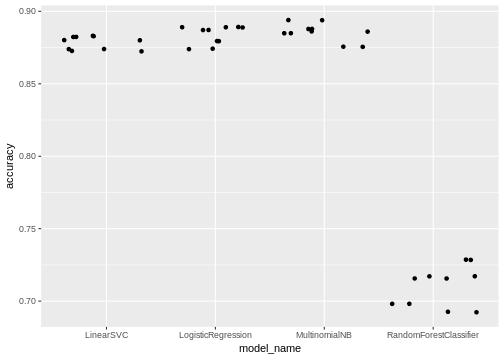

In [32]:
%%R -i cv_df -w 7 -h 5 -u in 

library(ggplot2)
ggplot(cv_df, aes(x= model_name)) +
    geom_jitter(aes(y = accuracy) )



##### DL methods

In [24]:
# basic block
from pytorch_transformers import *


class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)

    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)


config = Config(
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=1,
    use_fp16=True,
    bs= 32,
    discriminative=False,
    max_seq_len=128,
   # num_labels=4  # Remember to set the num_labels here
)

bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)


class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""

    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int = 128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t: str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]


fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(
    bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))



loss_func = nn.CrossEntropyLoss()


def loss_batch_bert(model: nn.Module, xb: Tensor, yb: Tensor, loss_func: OptLossFunc = None, opt: OptOptimizer = None,
                    cb_handler: Optional[CallbackHandler] = None) -> Tuple[Union[Tensor, int, float, str]]:
    "Calculate loss and metrics for a batch, call out to callbacks as necessary."
    cb_handler = ifnone(cb_handler, CallbackHandler())
    if not is_listy(xb):
        xb = [xb]
    if not is_listy(yb):
        yb = [yb]
    out = model(*xb)
    # pdb.set_trace()
    out = out[0]
    out = cb_handler.on_loss_begin(out)

    if not loss_func:
        return to_detach(out), yb[0].detach()
    loss = loss_func(out, *yb)

    if opt is not None:
        loss, skip_bwd = cb_handler.on_backward_begin(loss)
        if not skip_bwd:
            loss.backward()
        if not cb_handler.on_backward_end():
            opt.step()
        if not cb_handler.on_step_end():
            opt.zero_grad()

    return loss.detach().cpu()


# To change the loss_batch function in the loaded fastai module
module_basic_train = sys.modules['fastai.basic_train']
module_basic_train.loss_batch = loss_batch_bert
sys.modules['fastai.basic_train'] = module_basic_train

In [14]:
#train, val = train_test_split(df)
label_cols = ['class']

#bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels= config.num_labels)

accus = []

# use StratifiedKFold to CV 5 folds 
for train_idx, val_idx in StratifiedKFold(n_splits=5,  shuffle=True).split(df, df['class']):
    train = df.iloc[train_idx, :]
    val = df.iloc[val_idx, :]
    bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels= 4)
    
    databunch = TextDataBunch.from_df(AG_NEWS, train, val,
                      tokenizer=fastai_tokenizer,
                      vocab=fastai_bert_vocab,
                      include_bos=False,
                      include_eos=False,
                      text_cols= "describ",
                      label_cols=label_cols,
                      bs= 64,
                      collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
                 )
    
    learner = Learner(
    databunch, bert_model,
    loss_func=loss_func, metrics = accuracy)

    learner.fit_one_cycle(5, 1e-04)
    _, accu = learner.validate()
    accus.append(accu)
    


In [43]:
accus = [i.item() for i in accus]

In [44]:
accus

[0.9104999899864197,
 0.921500027179718,
 0.9235000014305115,
 0.9144999980926514,
 0.9114999771118164]

In [45]:
bert_agnews_accu_5 = pd.DataFrame({
    'model_name' : ['Bert'] * 5,
    'accuracy' : accus
})

bert_agnews_accu_5.to_csv(AG_NEWS/'bert_agnews_accu_5', index = False)
bert_agnews_accu_5 = pd.read_csv(AG_NEWS/'bert_agnews_accu_5')

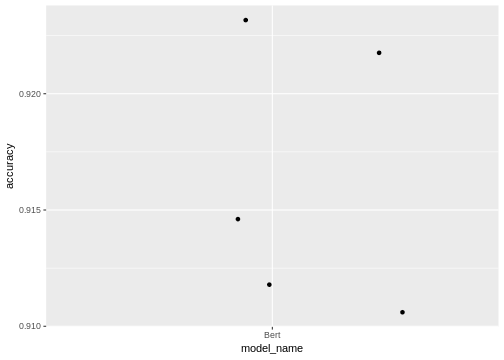

In [46]:
%%R -i bert_agnews_accu_5 -w 7 -h 5 -u in 
#library(ggplot2)
ggplot(bert_agnews_accu_5, aes(x= model_name)) +
    geom_jitter(aes(y = accuracy) )



#### Dbpedia data

##### ML part

In [10]:
df = DBPEDIA_TRAIN # set df as inner pointer to this dataset
df.head(2)

# Set the global vars for this dataset for diverse algorithums

df['category_id'] = df['class'].factorize()[0]

category_id_df = df[['class', 'category_id']
                    ].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = {v: k for k, v in category_to_id.items()}

tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', min_df=5,
                        encoding='latin-1', ngram_range=(1, 3), stop_words='english')

features = tfidf.fit_transform(df.contents).toarray()  # features is the global var for this dataset block

labels = df.category_id  # labels also a global var

features.shape  # of size (30000, 24903)

models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
          LinearSVC(),
          MultinomialNB(),
          LogisticRegression(random_state=0, max_iter= 200)]

boot_num = 2
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for i in range(boot_num):
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
        for _, accuracy in enumerate(accuracies):
            print(f'finished {model_name}, {i}th bootstrap of {_}th epochs')
            entries.append((model_name, accuracy))

        
cv_df = pd.DataFrame(entries, columns=['model_name', 'accuracy'])

finished RandomForestClassifier, 0th bootstrap of 0th epochs
finished RandomForestClassifier, 0th bootstrap of 1th epochs
finished RandomForestClassifier, 0th bootstrap of 2th epochs
finished RandomForestClassifier, 0th bootstrap of 3th epochs
finished RandomForestClassifier, 0th bootstrap of 4th epochs
finished LinearSVC, 0th bootstrap of 0th epochs
finished LinearSVC, 0th bootstrap of 1th epochs
finished LinearSVC, 0th bootstrap of 2th epochs
finished LinearSVC, 0th bootstrap of 3th epochs
finished LinearSVC, 0th bootstrap of 4th epochs
finished MultinomialNB, 0th bootstrap of 0th epochs
finished MultinomialNB, 0th bootstrap of 1th epochs
finished MultinomialNB, 0th bootstrap of 2th epochs
finished MultinomialNB, 0th bootstrap of 3th epochs
finished MultinomialNB, 0th bootstrap of 4th epochs
finished LogisticRegression, 0th bootstrap of 0th epochs
finished LogisticRegression, 0th bootstrap of 1th epochs
finished LogisticRegression, 0th bootstrap of 2th epochs
finished LogisticRegress

In [11]:
cv_df.to_csv(DBPEDIA/'ml_dbpedia_accu_10', index = False)
ml_dbpedia_accu_10 = pd.read_csv(DBPEDIA/'ml_dbpedia_accu_10')
ml_dbpedia_accu_10

,model_name,accuracy
0,RandomForestClassifier,0.811995
1,RandomForestClassifier,0.815374
2,RandomForestClassifier,0.817349
3,RandomForestClassifier,0.815553
4,RandomForestClassifier,0.818068
5,LinearSVC,0.976836
6,LinearSVC,0.975036
7,LinearSVC,0.976293
8,LinearSVC,0.971085
9,LinearSVC,0.970726


##### DL part

In [90]:
label_cols = ['class']
accus = []

# use StratifiedKFold to CV 5 folds 
for train_idx, val_idx in StratifiedKFold(n_splits=5,  shuffle=True).split(df, df['class']):
    train = df.iloc[train_idx, :]
    val = df.iloc[val_idx, :]
    bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels= 13)
    
    databunch = TextDataBunch.from_df(DBPEDIA, train, val,
                      tokenizer=fastai_tokenizer,
                      vocab=fastai_bert_vocab,
                      include_bos=False,
                      include_eos=False,
                      text_cols= "contents",
                      label_cols=label_cols,
                      bs= 64,
                      collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
                 )
    
    learner = Learner(
    databunch, bert_model,
    loss_func=loss_func, metrics = accuracy)

    learner.fit_one_cycle(5, 1e-04, moms=(0.8,0.7))
    _, accu = learner.validate()
    accus.append(accu)

epoch,train_loss,valid_loss,accuracy,time
0,0.101611,0.057224,0.988508,02:49
1,0.066836,0.067512,0.984917,02:49
2,0.039955,0.052604,0.988508,02:49
3,0.022419,0.044344,0.990663,02:49
4,0.012598,0.043295,0.992279,02:49


epoch,train_loss,valid_loss,accuracy,time
0,0.127935,0.071032,0.985991,03:11
1,0.081126,0.069929,0.984555,02:57
2,0.030810,0.064293,0.988147,03:08
3,0.015263,0.054442,0.988865,02:58
4,0.006597,0.059375,0.989045,02:51


epoch,train_loss,valid_loss,accuracy,time
0,0.122561,0.074562,0.986530,03:14
1,0.077386,0.065294,0.985991,02:50
2,0.038542,0.069332,0.983118,03:10
3,0.017741,0.053479,0.987967,03:09
4,0.012268,0.055812,0.990302,03:00


epoch,train_loss,valid_loss,accuracy,time
0,0.131571,0.073313,0.986889,03:19
1,0.074705,0.056656,0.987428,03:11
2,0.047166,0.055322,0.985632,03:13
3,0.019190,0.051438,0.988506,03:04
4,0.008112,0.050731,0.990122,03:19


epoch,train_loss,valid_loss,accuracy,time
0,0.132279,0.066882,0.987249,02:56
1,0.070772,0.063918,0.985991,03:17
2,0.040303,0.053309,0.988326,03:13
3,0.021852,0.054179,0.987249,02:49
4,0.008462,0.054850,0.987967,02:53


In [96]:
#learner.save('dbpedia_learner_bert')
learner.load('dbpedia_learner_bert')

Learner(data=TextClasDataBunch;

Train: LabelList (22273 items)
x: TextList
[CLS] ya ##s viceroy abu dhabi hotel is built across the f1 ya ##s marina circuit in abu dhabi . [SEP],[CLS] stephen fr ##ink is a prolific underwater photographer and frequent contributor to scuba diving magazine . fr ##ink was born in illinois and moved to key la ##rgo florida in 1978 where he currently lives with his wife and daughter . he is often cited as one of the most frequently published underwater photographers in the world . [ 1 ] [ 2 ] [ 3 ] [SEP],[CLS] diffuse kn ##ap ##weed ( cent ##aur ##ea di ##ff ##usa ) also known as white kn ##ap ##weed or tumble kn ##ap ##weed is a member of the genus cent ##aur ##ea in the family as ##tera ##ceae . [SEP],[CLS] dj ##ed ##i river ( french : ou ##ed dj ##ed ##i or ou ##ad - ed - dj ##ed ##i ) or dj ##edd ##i river is a wadi ( river with intermittent stream ) in algeria and one of the largest rivers of sahara . it starts in the saharan atlas mountains at elevat

In [97]:
interp = ClassificationInterpretation.from_learner(learner)

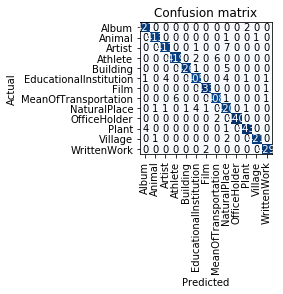

In [99]:
interp.plot_confusion_matrix()

In [93]:
accus = [i.item() for i in accus]
bert_dbpedia_accu_5 = pd.DataFrame({
    'model_name' : ['Bert'] * 5,
    'accuracy' : accus
})

bert_dbpedia_accu_5.to_csv(DBPEDIA/'bert_dbpedia_accu_5.csv', index = False)
bert_dbpedia_accu_5 = pd.read_csv(DBPEDIA/'bert_dbpedia_accu_5.csv')

#### Yelp review data

##### ML

In [25]:
df = YELP_TRAIN

In [26]:
df.shape

(12500, 3)

In [22]:
df = YELP_TRAIN # set df as inner pointer to this dataset
df.head(2)

# Set the global vars for this dataset for diverse algorithums

df['category_id'] = df['class'].factorize()[0]

category_id_df = df[['class', 'category_id']
                    ].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = {v: k for k, v in category_to_id.items()}

tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', min_df=5,
                        encoding='latin-1', ngram_range=(1, 3), stop_words='english')

features = tfidf.fit_transform(df.title).toarray()  # features is the global var for this dataset block

labels = df.category_id  # labels also a global var

features.shape  # of size (30000, 24903)

models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
          LinearSVC(),
          MultinomialNB(),
          LogisticRegression(random_state=0, max_iter= 200)]

boot_num = 2
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for i in range(boot_num):
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
        for _, accuracy in enumerate(accuracies):
            print(f'finished {model_name}, {i}th bootstrap of {_}th epochs')
            entries.append((model_name, accuracy))

        
cv_df = pd.DataFrame(entries, columns=['model_name', 'accuracy'])

KeyboardInterrupt: 

In [ ]:
cv_df.to_csv(YELP/'ml_yelp_accu_10', index = False)
ml_yelp_accu_10 = pd.read_csv(YELP/'ml_yelp_accu_10')
ml_yelp_accu_10

##### DL

In [ ]:
label_cols = ['class']
accus = []

# use StratifiedKFold to CV 5 folds 
for train_idx, val_idx in StratifiedKFold(n_splits=5,  shuffle=True).split(df, df['class']):
    train = df.iloc[train_idx, :]
    val = df.iloc[val_idx, :]
    bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels= 5 )
    
    databunch = TextDataBunch.from_df(YELP, train, val,
                      tokenizer=fastai_tokenizer,
                      vocab=fastai_bert_vocab,
                      include_bos=False,
                      include_eos=False,
                      text_cols= "title",
                      label_cols=label_cols,
                      bs= 72,
                      collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
                 )
    
    learner = Learner(
    databunch, bert_model,
    loss_func=loss_func, metrics = accuracy)
    #learner.load('premilinary_learner_Yelp_3epochs')

In [33]:
label_cols = ['class']
accus = []

# use StratifiedKFold to CV 5 folds 
for train_idx, val_idx in StratifiedKFold(n_splits=5,  shuffle=True).split(df, df['class']):
    train = df.iloc[train_idx, :]
    val = df.iloc[val_idx, :]
    bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels= 5 )
    
    databunch = TextDataBunch.from_df(YELP, train, val,
                      tokenizer=fastai_tokenizer,
                      vocab=fastai_bert_vocab,
                      include_bos=False,
                      include_eos=False,
                      text_cols= "title",
                      label_cols=label_cols,
                      bs= 72,
                      collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
                 )
    
    learner = Learner(
    databunch, bert_model,
    loss_func=loss_func, metrics = accuracy)
    #learner.load('premilinary_learner_Yelp_3epochs')
    learner.fit_one_cycle(6, 1e-04)
    _, accu = learner.validate()
    accus.append(accu)

epoch,train_loss,valid_loss,accuracy,time
0,1.301233,1.093577,0.521600,01:59
1,1.066599,1.036332,0.547600,01:58
2,0.883455,1.063862,0.554000,01:51
3,0.620126,1.193738,0.563200,02:03
4,0.306274,1.494803,0.555200,01:55
5,0.159709,1.614236,0.564400,01:55


epoch,train_loss,valid_loss,accuracy,time
0,1.258032,1.056155,0.545600,01:51
1,1.027700,1.038325,0.539200,01:58
2,0.831533,1.027231,0.566000,02:01
3,0.569622,1.179452,0.586000,02:00
4,0.300900,1.478549,0.586400,01:51
5,0.145904,1.583525,0.576000,02:02


epoch,train_loss,valid_loss,accuracy,time
0,1.264295,1.073345,0.528000,02:04
1,1.049571,1.103960,0.500400,02:02
2,0.808547,1.039969,0.575600,02:03
3,0.555421,1.243597,0.560000,01:51
4,0.280465,1.522083,0.577200,02:03
5,0.140278,1.657011,0.574000,01:58


epoch,train_loss,valid_loss,accuracy,time
0,1.263664,1.040612,0.541200,02:04
1,1.038413,1.003886,0.560000,01:51
2,0.808130,0.995627,0.578400,02:00
3,0.551050,1.160672,0.574400,01:56
4,0.275472,1.495857,0.579200,01:57
5,0.136960,1.593938,0.576000,01:55


epoch,train_loss,valid_loss,accuracy,time
0,1.264468,1.043323,0.528800,01:59
1,1.039918,1.003320,0.555200,02:02
2,0.843496,1.024616,0.554000,01:53
3,0.555465,1.190338,0.558000,02:03
4,0.274542,1.483281,0.566000,02:00
5,0.143104,1.600284,0.568800,01:58


In [34]:
accus = [i.item() for i in accus]
bert_yelp_accu_5 = pd.DataFrame({
    'model_name' :['Bert'] * 5,
    'accuracy' : accus
})

bert_yelp_accu_5.to_csv(YELP/'bert_yelp_accu_5.csv', index = False)
bert_yelp_accu_5 = pd.read_csv(YELP/'bert_yelp_accu_5.csv')

In [35]:
bert_yelp_accu_5

,model_name,accuracy
0,Bert,0.5644
1,Bert,0.5760
2,Bert,0.5740
3,Bert,0.5760
4,Bert,0.5688


In [36]:
learner.save('yelp_10k_learner')

In [37]:
interp_yelp_10k = ClassificationInterpretation.from_learner(learner)

In [47]:
pd.DataFrame(interp_yelp_10k.confusion_matrix()).to_csv('confusion_matrix_bert.csv')